In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from math import pi

In [2]:
# submit_record = pd.read_csv('path_to_your_data.csv')

relative_path = '../../sourcedata/'

# 读取题目信息 title = 题目
title_info = pd.read_csv(relative_path + 'Data_TitleInfo.csv')

# 读取学生信息 student = 学生
student_info = pd.read_csv(relative_path + 'Data_StudentInfo.csv')

# 读取学生答题记录
submit_record = pd.read_csv(relative_path + 'All_Class/all_class_submit_record.csv')

In [3]:
# 将时间戳转换为日期时间格式
submit_record['time'] = pd.to_datetime(submit_record['time'], unit='s')

# 提取时间特征
submit_record['hour'] = submit_record['time'].dt.hour
submit_record['day'] = submit_record['time'].dt.day
submit_record['weekday'] = submit_record['time'].dt.weekday
submit_record['month'] = submit_record['time'].dt.month

# 按时间特征统计答题量
hourly_data = submit_record.groupby('hour').size()
daily_data = submit_record.groupby('day').size()
weekly_data = submit_record.groupby('weekday').size()
monthly_data = submit_record.groupby('month').size()


In [4]:
# 答题正确率
submit_record['is_correct'] = submit_record['state'].apply(lambda x: 1 if x == 'Absolutely_Correct' else 0)

# 计算每个学生的每个1级知识点总的尝试次数
submit_record['attempts_per_kg'] = submit_record.groupby(['student_ID', 'knowledge'])['index'].transform('count')
# submit_record['score_per_kg'] = submit_record.groupby(['student_ID', 'knowledge'])['score'].transform('sum')
# 转换为宽格式 aggfunc='first'表示使用第一个值填充缺失值
knowledge_pivot = submit_record.pivot_table(index='student_ID', columns='knowledge', values='attempts_per_kg', aggfunc='first').fillna(0)
# score_pivot = submit_record.pivot_table(index='student_ID', columns='knowledge', values='score_per_kg', aggfunc='first').fillna(0)
# 重命名列名（可选）
knowledge_pivot.columns = [f'attempts_{col}' for col in knowledge_pivot.columns]
# score_pivot.columns = [f'score_{col}' for col in score_pivot.columns]

# 计算特征
features = submit_record.groupby('student_ID').agg({
    # 'score': ['mean', 'sum', 'count'],
    # 'score': 'sum',
    # 'is_correct': 'mean',# 计算每个学生每次提交的平均正确率，意义不大。而计算最终题目的正确率与后续单个知识点的正确率有有重叠，所以不需要
    # 'timeconsume': 'mean',
    # 'memory': 'mean',
    'hour': lambda x: x.value_counts().idxmax(), # 最常答题的时间段 匿名函数作用是返回出现次数最多的值 .value_counts()统计每个值出现的次数 .idxmax()返回出现次数最多的值
    # 'method': lambda x: x.value_counts().idxmax(), # 最常用的方法
    # 'title_ID': 'nunique', # 不同题目数量 尝试的题目数量
    # 'major': 'first',
})

# 这行代码的作用是将多级列索引转换为单级索引，并且分配容易理解的列名。
features.columns = [
    # 'score_mean', 'score_sum', 'score_count', 
    # 'score_sum', 
    # 'correct_rate', 
    # 'avg_timeconsume', 'avg_memory', 
    'most_common_hour', 
    # 'most_common_method', 
    # 'unique_questions'
    # 'major',
]

submit_record = submit_record.sort_values(by=['student_ID', 'title_ID', 'knowledge','score'], ascending=[True, True, True, False])
submit_record = submit_record.drop_duplicates(subset=['student_ID', 'title_ID', 'knowledge'], keep='first')
submit_record['score_ratio'] = submit_record['score'] / submit_record['full_score']

submit_record['score_ratio_per_kg'] = submit_record.groupby(['student_ID', 'knowledge'])['score_ratio'].transform('mean')
score_pivot = submit_record.pivot_table(index='student_ID', columns='knowledge', values='score_ratio_per_kg', aggfunc='first').fillna(0)
score_pivot.columns = [f'score_ratio_{col}' for col in score_pivot.columns]

# 计算学生总的得分
submit_record = submit_record.sort_values(by=['student_ID', 'title_ID', 'score'], ascending=[True, True, False])
submit_record = submit_record.drop_duplicates(subset=['student_ID', 'title_ID'], keep='first')
features['total_score'] = submit_record.groupby('student_ID')['score'].sum()


# 合并到特征表 how='left'表示左连接,左连接表示以左表为基础，右表中的数据只要在左表中有对应的就会被合并到一起，没有对应的就会被舍弃。
# fillna(0)表示将缺失值填充为0
features = features.merge(knowledge_pivot, on='student_ID', how='left').fillna(0)
features = features.merge(score_pivot, on='student_ID', how='left').fillna(0)

# 编码分类特征 .astype('category')表示将数据转换为分类数据，.cat.codes表示将分类数据转换为数值数据 
# 通过这种方式可以将分类数据转换为数值数据
# 对于某些非数值型特征（如小时、方法），我们需要将其转换为数值型以便于聚类分析。
# 作用是将最常答题的小时从类别类型转换为数值型编码。
features['most_common_hour'] = features['most_common_hour'].astype('category').cat.codes
# features['most_common_method'] = features['most_common_method'].astype('category').cat.codes
# features['major'] = features['major'].astype('category').cat.codes


# 对特征进行标准化
# scaler = StandardScaler()
# scaled_features = scaler.fit_transform(features)

# # 使用KMeans进行聚类
# kmeans = KMeans(n_clusters=3, random_state=42, init='k-means++', algorithm='lloyd', n_init='auto')
# features['cluster'] = kmeans.fit_predict(scaled_features)

e:\ProgramData\Anaconda3\envs\project_SONG\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
e:\ProgramData\Anaconda3\envs\project_SONG\Lib\site-packages\sklearn\base.py:1151: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


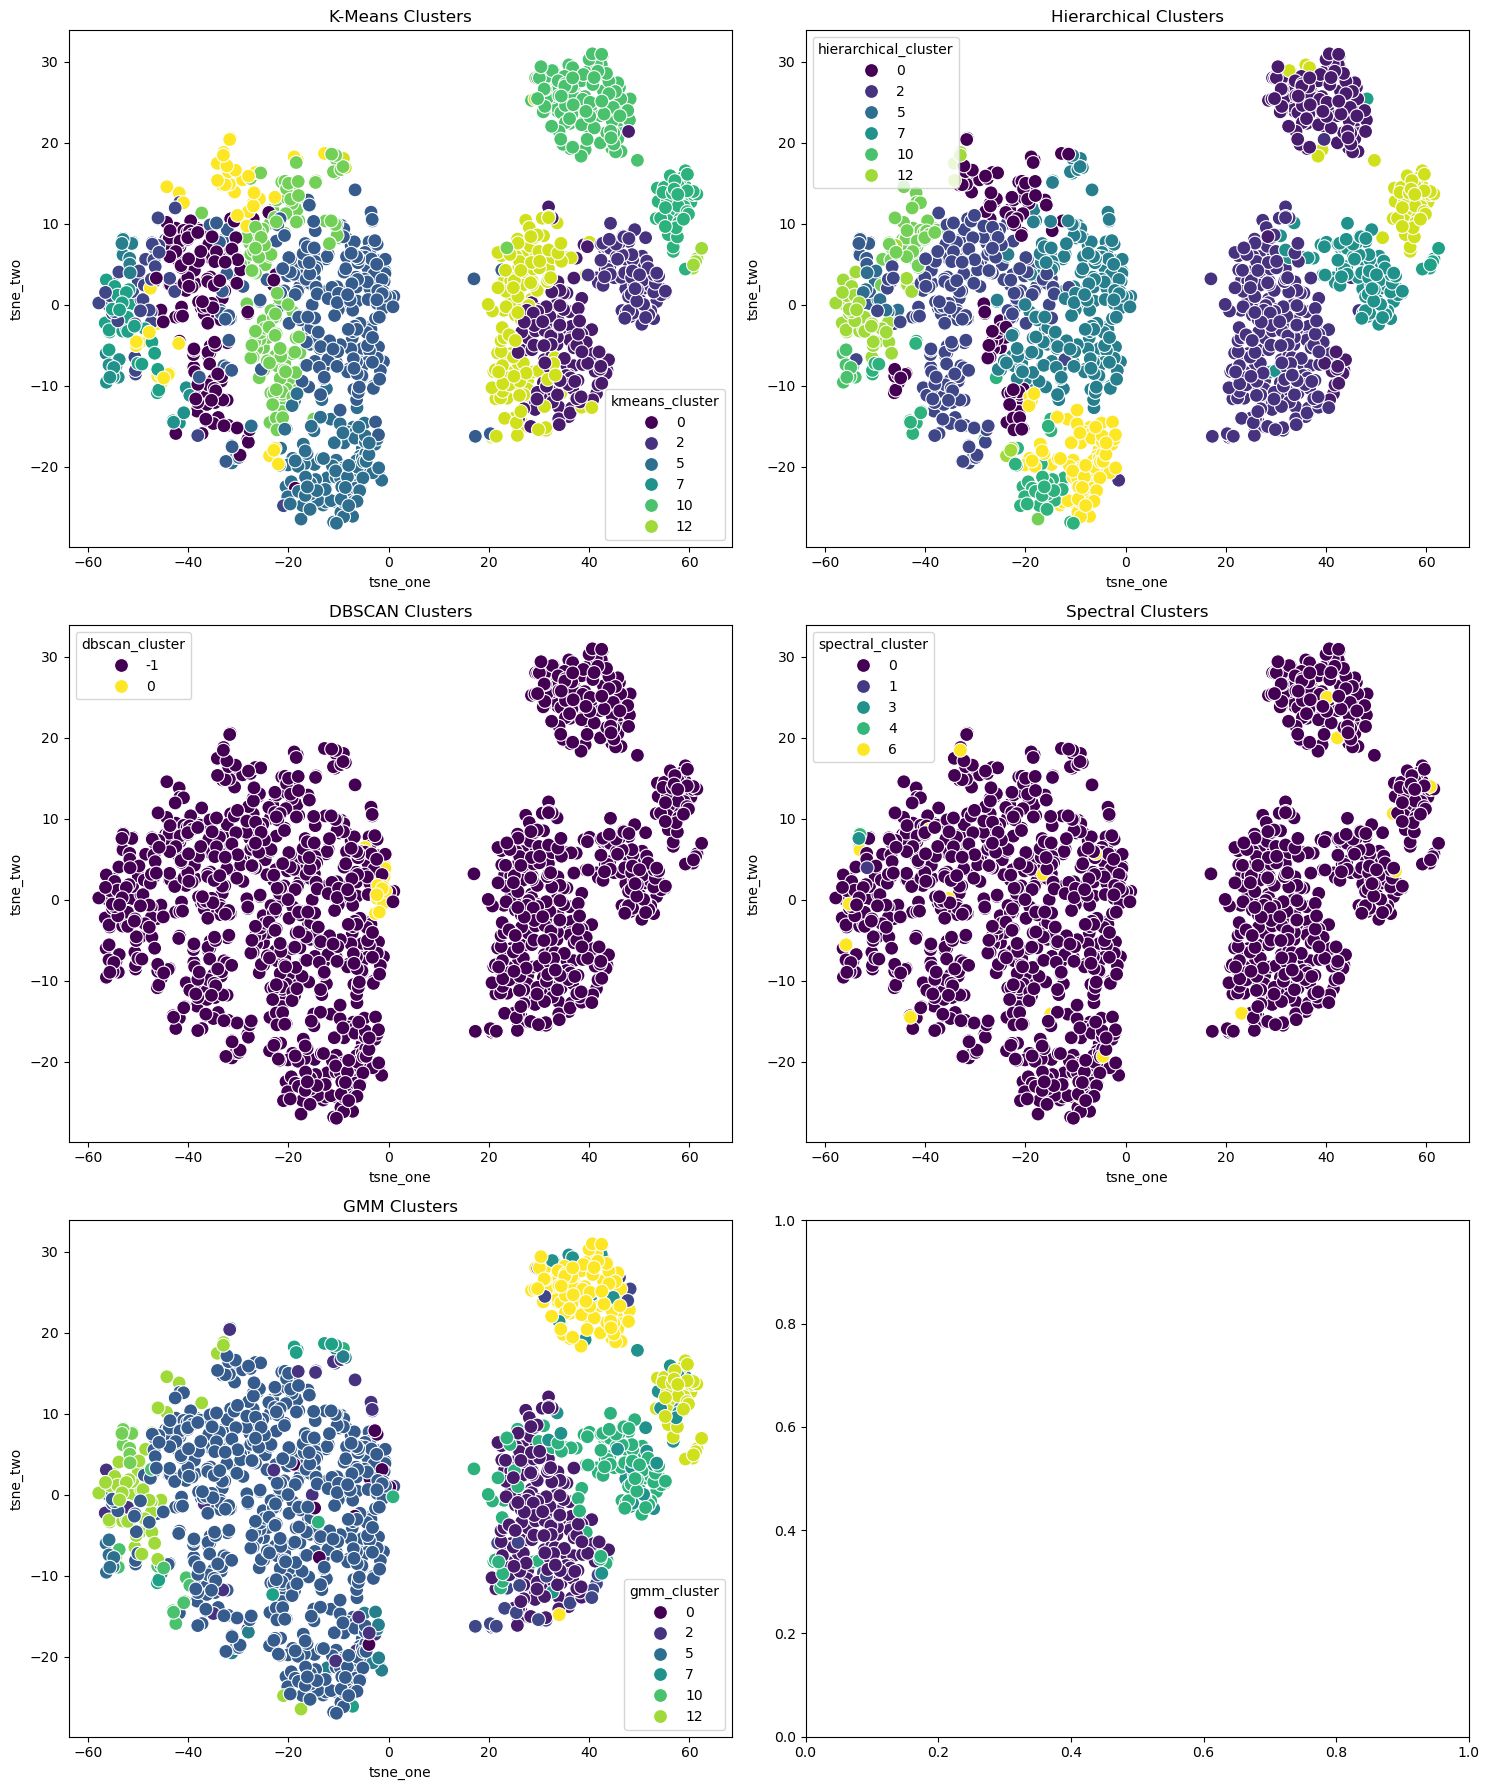

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# 标准化特征
scaler = StandardScaler()
if 'cluster' in features.columns:
    scaled_features = scaler.fit_transform(features.drop('cluster', axis=1))
else:
    scaled_features = scaler.fit_transform(features)
# KMeans
# kmeans = KMeans(n_clusters=15, random_state=42)
kmeans = KMeans(n_clusters=15, random_state=42, init='k-means++', algorithm='lloyd', n_init='auto')
features['kmeans_cluster'] = kmeans.fit_predict(scaled_features)
# 层次聚类
hierarchical = AgglomerativeClustering(n_clusters=15)
features['hierarchical_cluster'] = hierarchical.fit_predict(scaled_features)
# DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
features['dbscan_cluster'] = dbscan.fit_predict(scaled_features)
# 谱聚类
spectral = SpectralClustering(n_clusters=8, random_state=42)
features['spectral_cluster'] = spectral.fit_predict(scaled_features)
# 高斯混合模型
gmm = GaussianMixture(n_components=15, random_state=42)
features['gmm_cluster'] = gmm.fit_predict(scaled_features)



In [ ]:
# 降维
# t-SNE降维
tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(scaled_features)

# 添加t-SNE结果到features中
features['tsne_one'] = tsne_features[:, 0]
features['tsne_two'] = tsne_features[:, 1]

# 绘制不同聚类算法的t-SNE可视化结果
fig, axes = plt.subplots(3, 2, figsize=(15, 18))

# 绘制K-Means聚类结果
sns.scatterplot(data=features, x='tsne_one', y='tsne_two', hue='kmeans_cluster', palette='viridis', s=100, ax=axes[0, 0])
axes[0, 0].set_title('K-Means Clusters')

# 绘制层次聚类结果
sns.scatterplot(data=features, x='tsne_one', y='tsne_two', hue='hierarchical_cluster', palette='viridis', s=100, ax=axes[0, 1])
axes[0, 1].set_title('Hierarchical Clusters')

# 绘制DBSCAN聚类结果
sns.scatterplot(data=features, x='tsne_one', y='tsne_two', hue='dbscan_cluster', palette='viridis', s=100, ax=axes[1, 0])
axes[1, 0].set_title('DBSCAN Clusters')

# 绘制谱聚类结果
sns.scatterplot(data=features, x='tsne_one', y='tsne_two', hue='spectral_cluster', palette='viridis', s=100, ax=axes[1, 1])
axes[1, 1].set_title('Spectral Clusters')

# 绘制GMM聚类结果
sns.scatterplot(data=features, x='tsne_one', y='tsne_two', hue='gmm_cluster', palette='viridis', s=100, ax=axes[2, 0])
axes[2, 0].set_title('GMM Clusters')

plt.tight_layout()
plt.show()

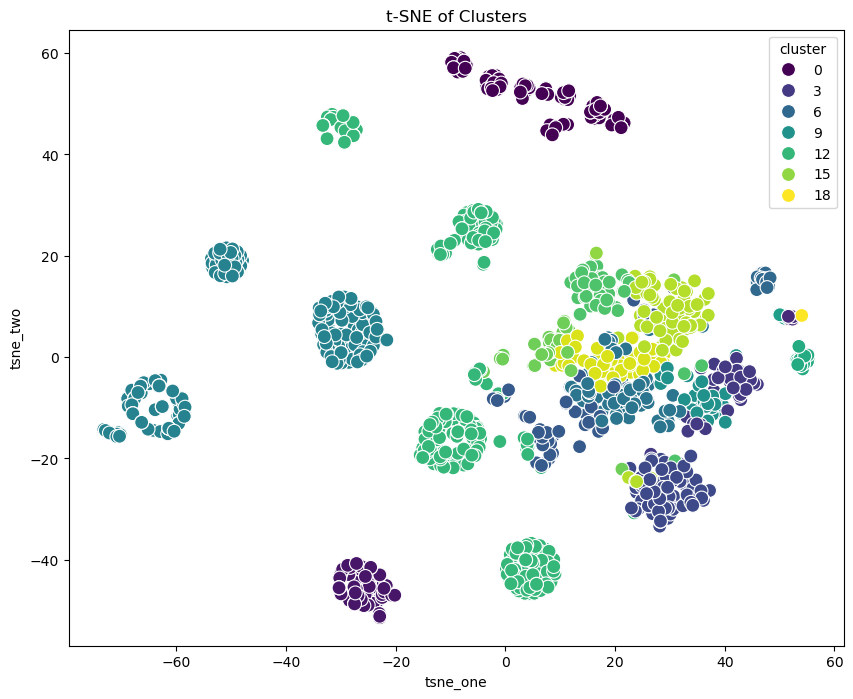

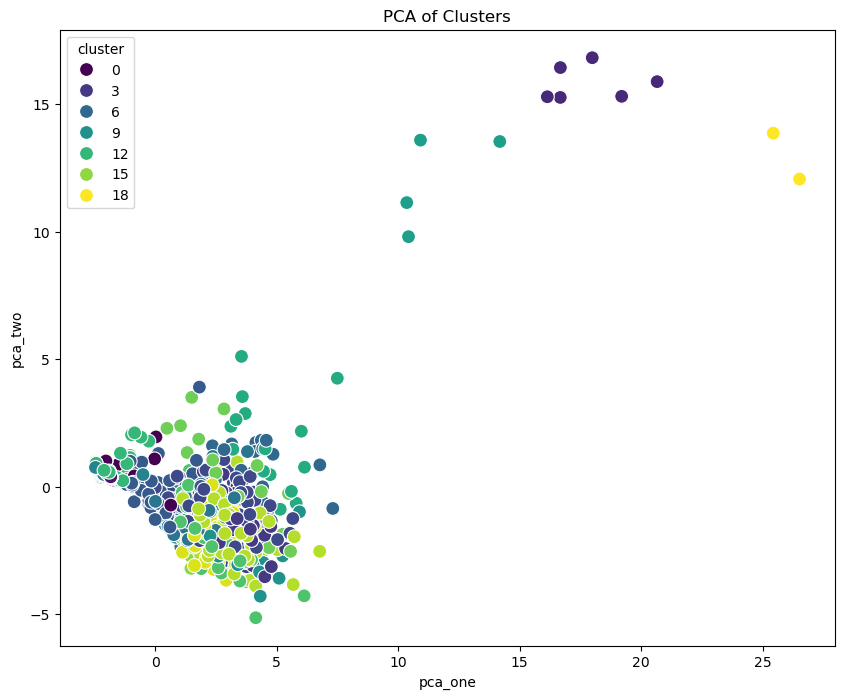

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# 假设 features 已经包含所有需要的特征列

# 标准化特征
scaler = StandardScaler()
if 'cluster' in features.columns:
    scaled_features = scaler.fit_transform(features.drop('cluster', axis=1))
else:
    scaled_features = scaler.fit_transform(features)

# KMeans聚类
optimal_k = 5  # 假设通过肘部法或轮廓系数法确定最佳K值为5
# kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans = KMeans(n_clusters=10, random_state=42, init='k-means++', algorithm='lloyd', n_init='auto')
features['cluster'] = kmeans.fit_predict(scaled_features)

# t-SNE降维
tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(scaled_features)
features['tsne_one'] = tsne_features[:, 0]
features['tsne_two'] = tsne_features[:, 1]

# PCA降维
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)
features['pca_one'] = pca_features[:, 0]
features['pca_two'] = pca_features[:, 1]

# 绘制t-SNE结果的散点图
plt.figure(figsize=(10, 8))
sns.scatterplot(data= , x='tsne_one', y='tsne_two', hue='cluster', palette='viridis', s=100)
plt.title('t-SNE of Clusters')
plt.show()

# 绘制PCA结果的散点图
plt.figure(figsize=(10, 8))
sns.scatterplot(data=features, x='pca_one', y='pca_two', hue='cluster', palette='viridis', s=100)
plt.title('PCA of Clusters')
plt.show()
